<a href="https://colab.research.google.com/github/theIcebaer/colab_notebooks/blob/main/setup_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In diesem Notebook wird ein Startpunkt für weitere Experimente gesetzt. Die zu lernenden Daten bestehen aus dem MNIST datensatz der durch ein einziges zufällig generiertes Flussfeld (flow field) verzerrt wurde. Dieses setup ist vor allem dazu da die technische basis für komplexere Experimente zu verifizieren. Außerdem werden technische Parameter des Trainings (batch size, num workers, etc...) in Abhängigkeit der zur verfügung stehenden Plattform  (google colab) erkundet.

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
#  !pip install imgaug==0.2.5
!pip install git+https://github.com/VLL-HD/FrEIA.git@v0.2
!pip install voxelmorph


  Cloning https://github.com/VLL-HD/FrEIA.git (to revision v0.2) to /tmp/pip-req-build-gofx3uw1
  Running command git clone -q https://github.com/VLL-HD/FrEIA.git /tmp/pip-req-build-gofx3uw1
  Running command git checkout -q 033f6fd6eb4d2ddbc98f746a9ef5f8c619587abe
  Created wheel for FrEIA: filename=FrEIA-0.2-cp37-none-any.whl size=29683 sha256=ac33ef70d37ae1db9710d3576ac8a5b33ff187c21a7d895d61eb2d9385fbd799
  Stored in directory: /tmp/pip-ephem-wheel-cache-s0rus4iu/wheels/c8/44/55/41fb9ebf2069a37f4a16c63c601ffaaf9ed61609761c7bd55e
Successfully built FrEIA
     |████████████████████████████████| 81kB 4.5MB/s 
     |████████████████████████████████| 92kB 8.9MB/s 


In [4]:
import torch
import torch.nn as nn

import torchvision
import torchvision.datasets as datasets
import torch.utils as utils

import FrEIA.framework as Ff
import FrEIA.modules as Fm

import numpy as np
import copy
import pdb

%pdb off

Automatic pdb calling has been turned OFF


In [5]:
DEBUG = False

In [6]:
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.ReLU(),
                        nn.Linear(512,  c_out))

def subnet_conv(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   3, padding=1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 3, padding=1))

def subnet_conv_1x1(c_in, c_out):
    return nn.Sequential(nn.Conv2d(c_in, 256,   1), nn.ReLU(),
                        nn.Conv2d(256,  c_out, 1))

In [7]:
!ls /content/gdrive/MyDrive/code/data/data_generation

big_dummy_data	mnist_distortions_10_fields.dat  mnist_rnd_distortions_1.dat
dummy_data.dat	mnist_distortions_20_fields.dat  __pycache__
gen_data.py	mnist_distortions_2_fields.dat	 utils.py
mnist_data	mnist_distortions.dat


In [8]:
# mnist_dist = torch.load("/content/gdrive/MyDrive/gd_thesis/mnist_rnd_distortions_10.dat")

In [9]:
# mnist_dist.keys()
# original= mnist_dist['original_image']
# original.shape

In [10]:
n_epochs = 60
batch_size = 64

In [48]:

device = 'cuda'

# data_dict = torch.load("/content/gdrive/MyDrive/code/data/data_generation/big_dummy_data")
data_dict = torch.load("/content/gdrive/MyDrive/gd_thesis/mnist_rnd_distortions_10.dat")
# data_dict = torch.load("/content/gdrive/MyDrive/code/data/data_generation/mnist_rnd_distortions_1.dat")

for k in data_dict:
    print(k)

original
vfield
transformed
deformations
description


In [49]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader



print(data_dict['original'].shape, data_dict['transformed'].shape )

conditions = torch.cat([data_dict['original'], data_dict['transformed']], dim=1)
deformations = data_dict['deformations']
velocities = data_dict['vfield']

print(velocities.shape)

# train_x, train_c = velocities[:45000].float(), conditions[:45000].float()
# test_x, test_c = velocities[45000:55000].float(), conditions[45000:55000].float()

# val_x, val_c = velocities[55000:].float(), conditions[55000:].float()


# train_set = TensorDataset(train_x, train_c)
# train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# test_set = TensorDataset(test_x, test_c)
# test_loader = DataLoader(test_set, batch_size=batch_size)
# val_set = TensorDataset(val_x, val_c)
# val_loader = DataLoader(val_set, batch_size=128)

data_set = TensorDataset(velocities.float(), conditions.float())

train_set, val_set, test_set = torch.utils.data.random_split(data_set, [47712, 4096, 8192], generator=torch.Generator().manual_seed(42))
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128)
test_loader = DataLoader(test_set, batch_size=batch_size)
print(len(val_set))

torch.Size([60000, 1, 28, 28]) torch.Size([60000, 1, 28, 28])
torch.Size([60000, 2, 28, 28])
4096


In [50]:
55904- (4096 * 2)

47712

In [51]:
uniques = np.unique(velocities, axis=0)
uniques.shape

(10, 2, 28, 28)

In [52]:
# import matplotlib.pyplot as plt


# u,v = 
# sd



In [53]:
class Reg_mnist_cINN(nn.Module): 
    def __init__(self):
        super(Reg_mnist_cINN, self).__init__()
        self.flat_layer = torch.nn.Flatten(start_dim=1, end_dim=-1)
        self.cinn = self.build_inn()

    def build_inn(self):

            def subnet(ch_in, ch_out):
                return nn.Sequential(nn.Linear(ch_in, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, ch_out))

            cond = Ff.ConditionNode(2 * 28 * 28, name='condition')
            nodes = [Ff.InputNode(2, 28, 28, name='flat')]

            nodes.append(Ff.Node(nodes[-1], Fm.Flatten, {}, name='flat'))

            for k in range(20):
                nodes.append(Ff.Node(nodes[-1], Fm.PermuteRandom , {'seed':k}, name="permute_{}".format(k)))
                nodes.append(Ff.Node(nodes[-1], Fm.GLOWCouplingBlock,
                                    {'subnet_constructor':subnet, 'clamp':1.0},
                                    conditions=cond,
                                    name="Coupling_Block_{}".format(k)))

            return Ff.ReversibleGraphNet(nodes + [cond, Ff.OutputNode(nodes[-1])], verbose=False)

    def forward(self, x, c, rev=False):
        z = self.cinn(x, [self.flat_layer(c)], rev=rev)
        log_j = self.cinn.log_jacobian(run_forward=False)
        return z, log_j

    def reverse_sample(self, z, c):
        # x = self.cinn((x, [self.flat_layer(c)], rev=True))
        # return x
        pass
        
cinn = Reg_mnist_cINN()

        

In [54]:
checkpoints = []

# cinn_new = Ff.SequenceINN(28* 28)
# cinn_new.append(Ff.Node())
# for k in range(20):
#     cinn_new.append(Fm.AllInOneBlock, cond=0, cond_shape=(10,), subnet_constructor=subnet_fc)


for p in cinn.parameters():
    if p.requires_grad:
        p.data = 0.01 * torch.randn_like(p)

train_params = [p for p in cinn.parameters() if p.requires_grad]






In [55]:
device = torch.device("cuda")
cinn.to(device)
print("done")

done


In [57]:
# def early_stop(val_history, train_history):
#     diff = np.mean(np.abs(val_history[-20:] - train_history[-20]))
#     relative_diff = 
#     if diff > 
    

In [ ]:
augm_sigma = 0.08
ndim_total = 2* 28*28



cinn.train()

#print(next(cinn.parameters()).device)
print(n_epochs)

optimizer = torch.optim.Adam(train_params, lr=5e-4,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[20, 40], gamma=0.1)


print("epoch \t batch \t nll \t aggregated nll \t validation nll")

val_x, val_c = next(iter(val_loader))
val_x, val_c = val_x.to(device), val_c.to(device)

loss_log = {"nll": [],
            "val_nll": [],
            "epoch": [],
            "batch": []}


for e in range(n_epochs):
    agg_nll = []
    for i, (im, cond) in enumerate(train_loader):
        # if DEBUG:
        #print("batch {} ------------------".format(i))
        #print("image shape", im.shape)
        #print("cond shape", cond.shape)


        #print("device", device)
        im = im.to(device)
        cond = cond.to(device)


        if DEBUG:
            print("DEBUG device image:", im.shape)
            print("DEBUG device conditions:", cond.shape)
        
        
        #one_hot_labels = torch.nn.functional.one_hot(cond, num_classes=10)
        #flat_im = torch.nn.Flatten(im, start_dim=1)
        if DEBUG:
            print("image shape flattened", flat_im.shape)
            print("label shape, one hot encoded", one_hot_labels.shape)

            print("DEBUG device flat image:", flat_im.device)
            print("DEBUG device flat labels:", one_hot_labels.device)
        out, log_j = cinn(im, c=cond)
        # print(out.shap)
        # print('outshape',(out**2 / 2).shape)
        # print('logshape', (log_j / ndim_total).shape)
        # print("term", (out**2 / 2 - log_j / ndim_total).shape)




        # print("SHAPE:", out.shape )

        # nll = torch.mean(torch.norm(out, p=2)**2/2 - log_j) / ndim_total

        # print("out shape", out.shape)
        # print(log_j.shape)
        # print("cinn mean", torch.mean(out**2))
        # print("my mean", torch.mean(torch.sum(out**2)))
        alt_nll = torch.mean(out**2 / 2) - torch.mean(log_j) / ndim_total

        nll = 0.5 * torch.sum(out**2, dim=1) - log_j
        nll = torch.mean(nll)/ndim_total

        #agg_nll.append(nll.cpu().detach().numpy())

        #old_params = copy.deepcopy(train_params)
        
        if DEBUG:
            print(nll.shape)
        alt_nll.backward()

        #print("{}\t{}\t{}".format(e, i, alt_nll.item()))

        torch.nn.utils.clip_grad_norm_(train_params, 10.)


        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()

        #diff = []
        
        #for i , _ in enumerate(train_params):
        #   diff.append(train_params[i] - old_params[i])

        #print("diff {} ---------------------------\n".format(i), diff)
        #break

        if i % 20 == 0:
            with torch.no_grad():
                    
                v_out, v_log_j = cinn(val_x, c=val_c)
                v_nll =  torch.mean(v_out**2) / 2 - torch.mean(v_log_j) / ndim_total
                loss_log['nll'].append(alt_nll.item())
                loss_log['val_nll'].append(v_nll.item())
                loss_log['epoch'].append(e)
                loss_log["batch"].append(i)
                print("{}\t{}\t{}\t{}\t{}".format(e, i, alt_nll.item(),nll.item(), v_nll.item()))


                
            
        #         a_nll = np.mean(agg_nll)
                # mean_v_nll = np.mean(agg_v_nll)
                # print("{}\t{}\t{}\t{}".format(e, i, alt_nll.item(), mean_v_nll.item()))
        #         agg_nll = []

        #         checkpoint = {
        #             "model": cinn,
        #             "state_dict": cinn.state_dict(),
        #             "opimizer_state": optimizer.state_dict(),
        #             "scheduler_state": scheduler.state_dict()
        #             }
        #         checkpoints.append(checkpoint)
        
torch.save(cinn.state_dict(), "/content/gdrive/MyDrive/code/data/setup_0_modelparams.pt")

60
epoch 	 batch 	 nll 	 aggregated nll 	 validation nll
0	0	4.1792192459106445	4.1792192459106445	1.8231616020202637
0	20	-0.8826965093612671	-0.8826965093612671	-0.9094732403755188
0	40	-1.7305994033813477	-1.7305995225906372	-1.7003722190856934
0	60	-1.7658026218414307	-1.7658025026321411	-1.819945216178894
0	80	-1.9334427118301392	-1.9334427118301392	-1.8734632730484009
0	100	-1.942234754562378	-1.9422348737716675	-1.9176757335662842
0	120	-1.9542512893676758	-1.9542512893676758	-1.9579694271087646
0	140	-2.01790189743042	-2.01790189743042	-1.9952399730682373
0	160	-2.004615545272827	-2.004615545272827	-2.029900312423706
0	180	-2.0874056816101074	-2.0874059200286865	-2.0612387657165527
0	200	-2.1114587783813477	-2.1114587783813477	-2.0938775539398193
0	220	-2.0717718601226807	-2.0717720985412598	-2.12595534324646
0	240	-2.1673882007598877	-2.1673882007598877	-2.1522889137268066
0	260	-2.180452823638916	-2.180452823638916	-2.1819677352905273
0	280	-2.2095768451690674	-2.209577322006

In [47]:
# import copy
# cinn2 = copy.deepcopy(cinn)

In [43]:


def store_run(model, loss_log, hyperparams):
    "this should store all information needed from a setup to restore the experiment for reconstruction and further discussion."
    import time
    import datetime
    import os 
    path = os.path.join("/content/gdrive/MyDrive/runs/", datetime.datetime.now().strftime('%Y-%m-%d_%H-%M'))
    
    if not os.path.exists(path):
        os.makedirs(path)
    print(path)
    
    desc = "cINN model with only fully connected inn-modules. 5 of them."

    
    #torch.save(model, os.path.join(path, "full_model.pt"))
    torch.save(model.state_dict(),  os.path.join(path, "model_state_dict"))
    #torch.save(optimizer, os.path.join(path, "full_optimizer.pt"))
    torch.save(optimizer.state_dict(),  os.path.join(path, "optimizer_state_dict.dict"))            
    #torch.save(scheduler, os.path.join(path, "full_scheduler.pt"))
    torch.save(scheduler.state_dict(),  os.path.join(path, "scheduler_state_dict.dict"))         
    torch.save(loss_log, os.path.join(path, "loss_log.log"))# loss_log
    torch.save(hyperparams, os.path.join(path, "hyperparams.dict"))# hyperparams

    

    return True

hyperparams = {"n_epochs": 60,
               "batch_size": 64,
               "normalization": True,
               "model_depth": 5,
               "github": "colab_notebooks - ed6442f0bd3aac7aa30cb552a1332c2185c04974"}

store_run(cinn, loss_log, hyperparams)

/content/gdrive/MyDrive/runs/2021-07-15_15-48


True

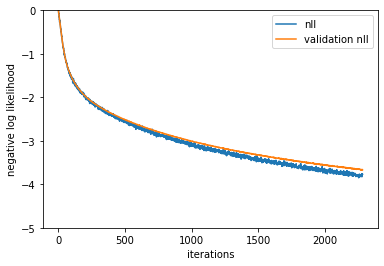

In [44]:
# lets do some plots
import matplotlib.pyplot as plt

# training progression plot
fig = plt.figure()
plt.plot(loss_log['nll'], label='nll')
plt.plot(loss_log['val_nll'], label='validation nll')
# plt.yscale("log")
plt.ylim([-5,0])
plt.xlabel("iterations")
plt.ylabel("negative log likelihood")
plt.legend()

plt.show()






In [45]:
# x, c = next(iter(test_loader))
# xt, ct = next(iter(train_loader))

# x_pred, _ = cinn(xt, c=ct)

# print(c.shape, ct.shape)
# torch.save(cinn.state_dict(), "/content/gdrive/MyDrive/code/cinn.pt")
# torch.save(cinn,  "/content/gdrive/MyDrive/code/cinn.model")

# torch.save(cinn.state_dict())
from voxelmorph.torch.layers import VecInt
from voxelmorph.torch.layers import SpatialTransformer

def apply_flow (volume, v_field, device=torch.device('cpu')):
    if type(volume) == np.ndarray:
        volume = torch.from_numpy(volume)
    if type(v_field) == np.ndarray:
        v_field = torch.from_numpy(v_field)

    # volume = volume.to(device)
    # v_field = v_field.to(device)
    
    integrator = VecInt(inshape=v_field.shape[2:], nsteps=7).to(device)
    transformer = SpatialTransformer(size=volume.shape[2:]).to(device)
    deformation = integrator(v_field)
    transformed = transformer(volume, deformation)
    return transformed, deformation

torch.Size([28, 28])


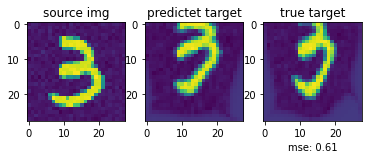

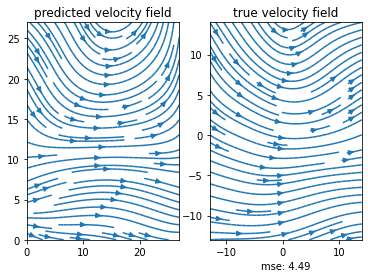

torch.Size([28, 28])


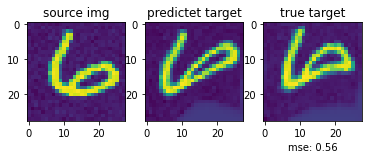

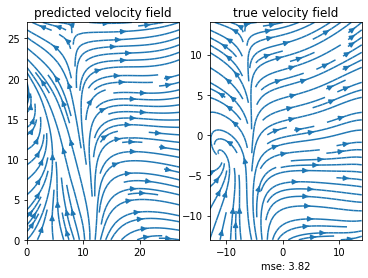

torch.Size([28, 28])


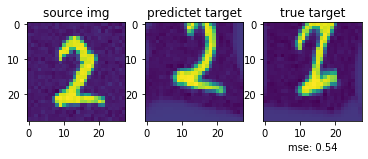

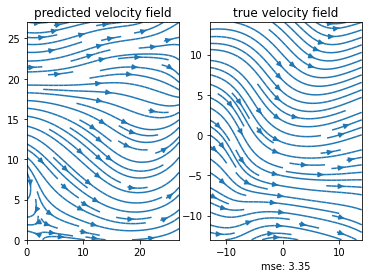

torch.Size([28, 28])


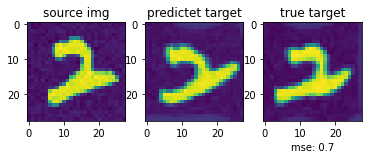

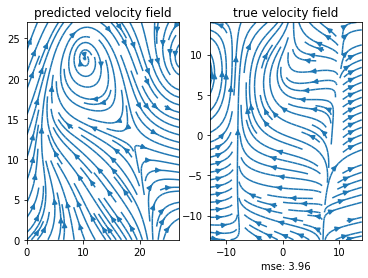

torch.Size([28, 28])


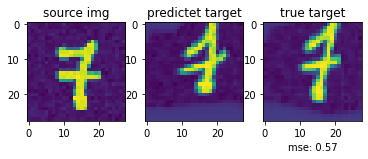

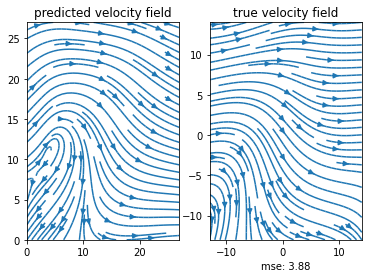

torch.Size([28, 28])


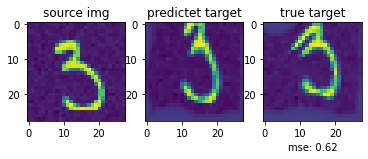

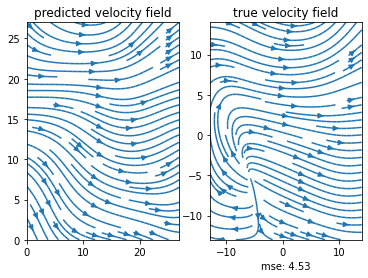

torch.Size([28, 28])


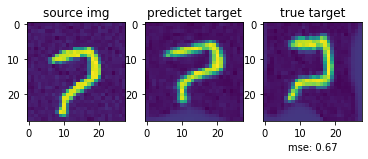

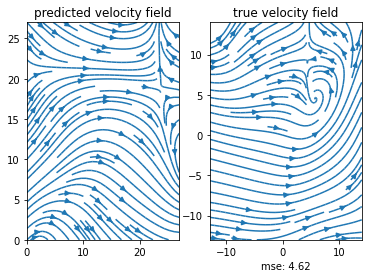

torch.Size([28, 28])


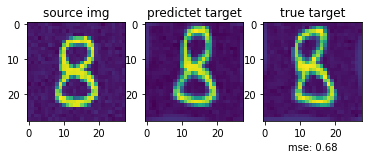

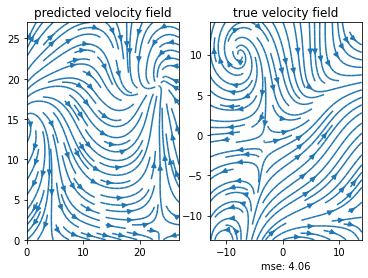

torch.Size([28, 28])


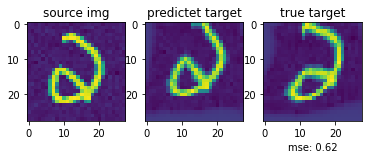

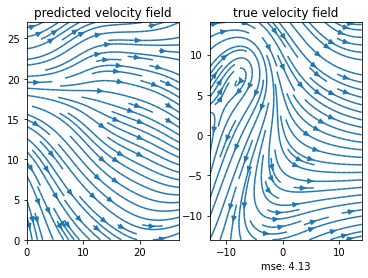

torch.Size([28, 28])


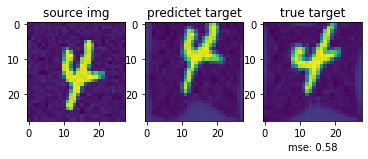

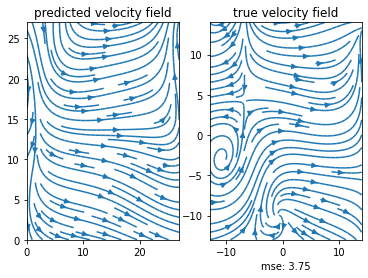

torch.Size([28, 28])


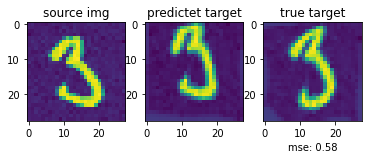

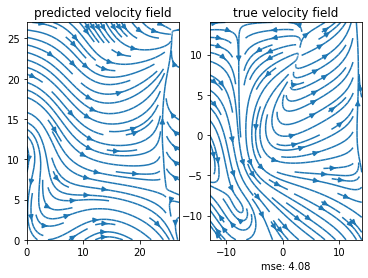

torch.Size([28, 28])


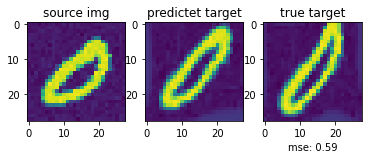

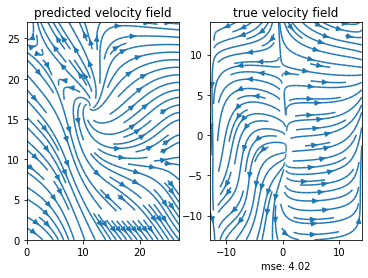

torch.Size([28, 28])


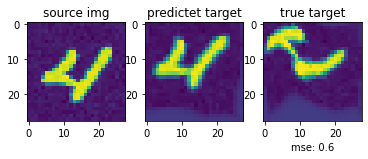

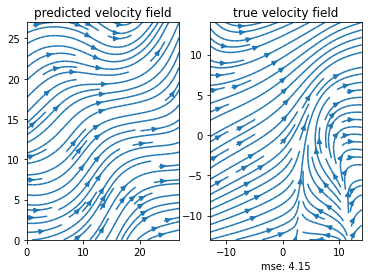

torch.Size([28, 28])


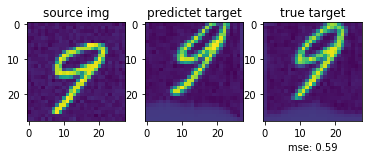

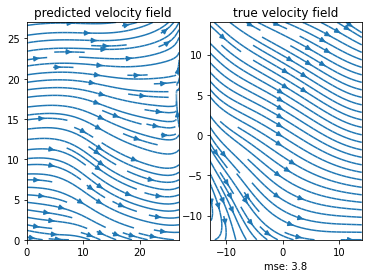

torch.Size([28, 28])


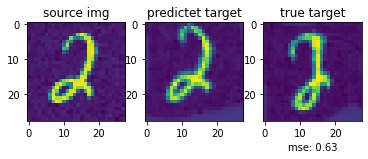

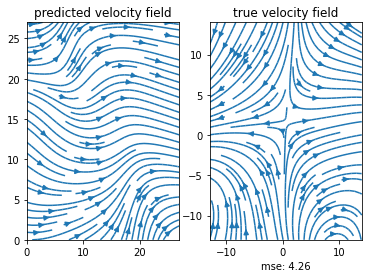

torch.Size([28, 28])


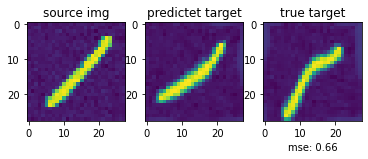

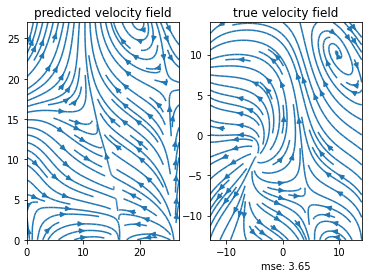

torch.Size([28, 28])


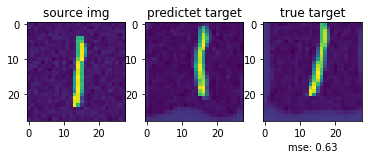

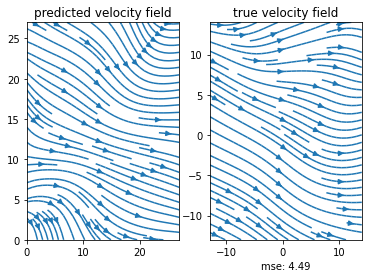

torch.Size([28, 28])


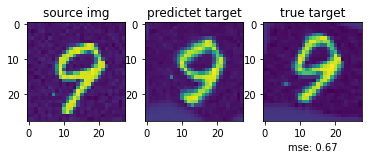

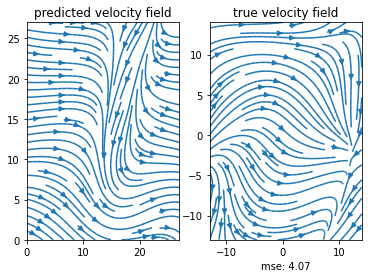

torch.Size([28, 28])


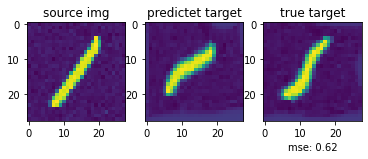

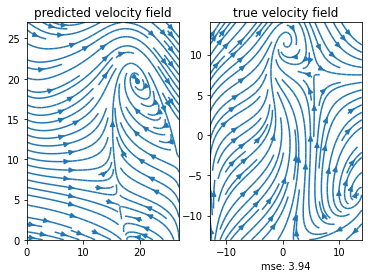

torch.Size([28, 28])


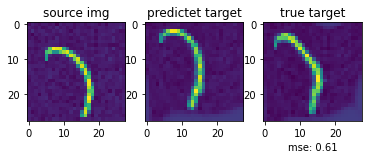

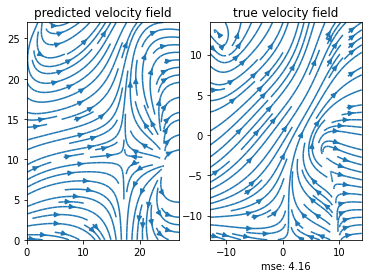

torch.Size([28, 28])


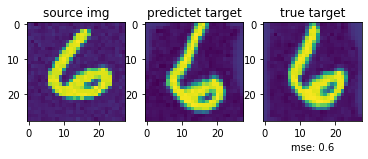

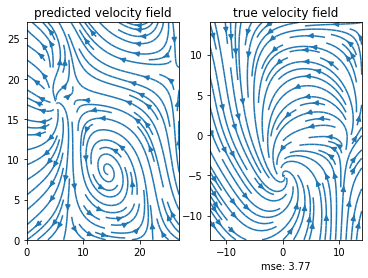

torch.Size([28, 28])


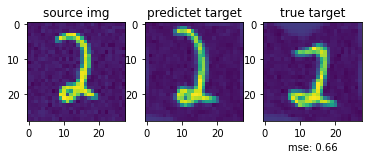

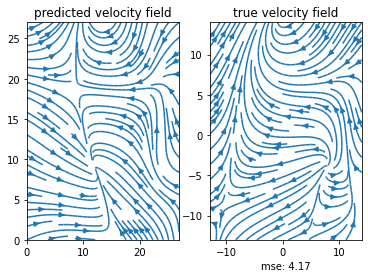

torch.Size([28, 28])


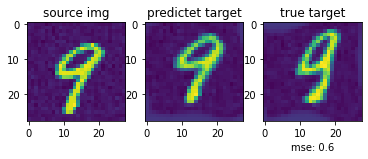

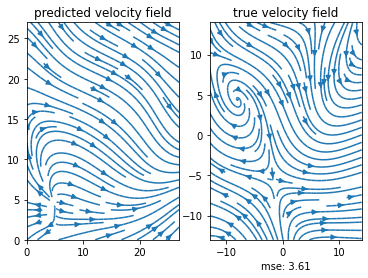

torch.Size([28, 28])


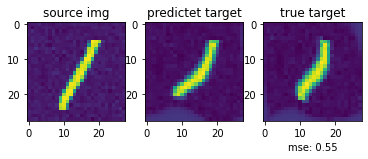

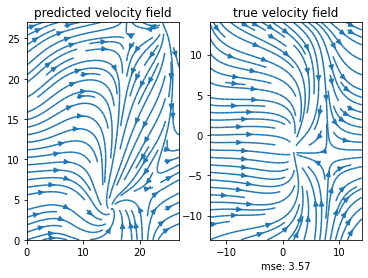

torch.Size([28, 28])


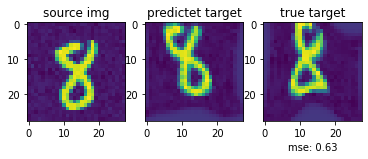

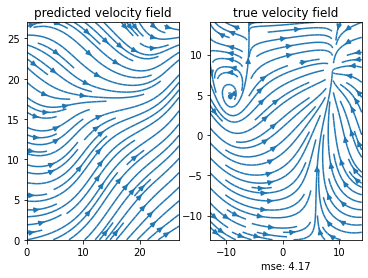

torch.Size([28, 28])


KeyboardInterrupt: ignored

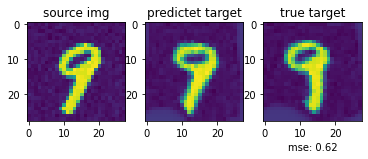

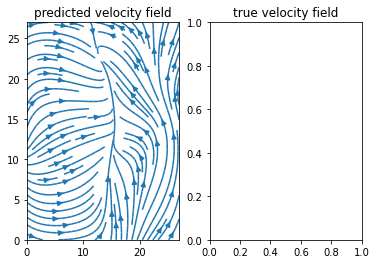

In [46]:
import matplotlib.pyplot as plt

mse = torch.nn.MSELoss()

plot = True



# z = torch.randn(batch_size, ndim_total)
# x_pred, _ = cinn(x, c=c, rev=False)  # predicted ve


cinn.eval()

next(cinn.parameters()).device
with torch.no_grad():

    field_err = []
    reconstruction_err = []
    
    for v_field, c in test_loader:

        v_field = v_field.to(device)
        # print(v_field.shape)
        c = c.to(device)
        # x = true field
        # c = condition vector of composed moving and fixed image (m,f)
        z = torch.randn(batch_size, 2*28*28).to(device)
        v_field_pred, _ = cinn(z, c=c, rev=True)  # predicted velocity field
        
        source_imgs = c[:, 0, ...]
        
        source = c[:, :1, ...].to(device)
        target = c[:, 1:, ...].to(device)
        
        target_pred, _ = apply_flow(v_field=v_field_pred, volume=source, device=device)

        
        field_err.append(mse(v_field, v_field_pred).item())
        reconstruction_err.append(mse(target, target_pred).item())

        if plot:
            source = source.to(torch.device("cpu"))
            target = target.to(torch.device("cpu"))
            target_pred = target_pred.to(torch.device("cpu"))
            v_field = v_field.to(torch.device("cpu"))
            v_field_pred = v_field_pred.to(torch.device("cpu"))

            # print(v_field.shape)
            # print(v_field_pred.shape)   
            
            fig = plt.figure()

            idx = np.random.randint(source.shape[1])


            ax1 = fig.add_subplot(1, 3, 1)
            ax1.set_title("source img")
            ax1.imshow(source[idx, 0, :, :])
            
            
            ax2 = fig.add_subplot(1, 3, 2)
            ax2.set_title("predictet target")
            ax2.imshow(target_pred[idx, 0, :, :])

            ax3 = fig.add_subplot(1, 3, 3)
            ax3.set_title("true target")
            ax3.imshow(target[idx, 0, :, :])
            ax3.set_xlabel("mse: {}".format(round(reconstruction_err[-1],2)))

            fig2 = plt.figure()

            ax4 = fig2.add_subplot(1, 2, 1)
            ax4.set_title("predicted velocity field")
            # ax4.imshow(v_field_pred[idx, 0, :, :])
            u,v = v_field_pred[idx, 0, :, :], v_field_pred[idx,1,:,:]
            x,y = np.meshgrid(np.linspace(0, 27,28),np.linspace(0,27,28))
            plt.streamplot(x,y, u,v)

            ax5 = fig2.add_subplot(1, 2, 2)
            ax5.set_title("true velocity field")
            # ax5.imshow(v_field[idx, 0, :, :])
            u,v = v_field[idx,0], v_field[idx,1]
            print(u.shape)
            x,y = np.meshgrid(np.linspace(-13, 14,28),np.linspace(-13,14,28))
            plt.streamplot(x,y, u,v)
            ax5.set_xlabel("mse: {}".format(round(field_err[-1], 2)))

            


            plt.show()

In [ ]:
def evalutate(cinn, test_loader, idx=None, plot=True):
    mse = torch.nn.MSELoss()

    cinn.eval()

    with torch.no_grad():

        field_err = []
        reconstruction_err = []
        
        for v_field, c in test_loader:

            v_field = v_field.to(device)
            c = c.to(device)
            # x = true field
            # c = condition vector of composed moving and fixed image (m,f)
            z = torch.randn(batch_size, ndim_total).to(device)
            v_field_pred, _ = cinn(z, c=c, rev=True)  # predicted velocity field
            
            source_imgs = c[:, 0, ...]
            
            source = c[:, :1, ...].to(device)
            target = c[:, 1:, ...].to(device)
            
            target_pred, _ = apply_flow(v_field=v_field_pred, volume=source, device=device)

            
            field_err.append(mse(v_field, v_field_pred).item())
            reconstruction_err.append(mse(target, target_pred).item())

            if plot:
                source = source.to(torch.device("cpu"))
                target = target.to(torch.device("cpu"))
                target_pred = target_pred.to(torch.device("cpu"))
                v_field = v_field.to(torch.device("cpu"))
                v_field_pred = v_field_pred.to(torch.device("cpu"))
                
                fig = plt.figure()

                idx = np.random.randint(source.shape[1])


                ax1 = fig.add_subplot(1, 3, 1)
                ax1.set_title("source img")
                ax1.imshow(source[idx, 0, :, :])
                
                
                ax2 = fig.add_subplot(1, 3, 2)
                ax2.set_title("predictet target")
                ax2.imshow(target_pred[idx, 0, :, :])

                ax3 = fig.add_subplot(1, 3, 3)
                ax3.set_title("true target")
                ax3.imshow(target[idx, 0, :, :])
                ax3.set_xlabel("mse: {}".format(round(reconstruction_err[-1],2)))

                fig2 = plt.figure()

                ax4 = fig2.add_subplot(1, 2, 1)
                ax4.set_title("predicted velocity field")
                # ax4.imshow(v_field_pred[idx, 0, :, :])
                u,v = v_field_pred[idx,0], v_field_pred[idx,1]
                x,y = np.meshgrid(np.linspace(-13, 14,28),np.linspace(-13,14,28))
                plt.streamplot(x,y, u,v)

                ax5 = fig2.add_subplot(1, 2, 2)
                ax5.set_title("true velocity field")
                # ax5.imshow(v_field[idx, 0, :, :])
                u,v = v_field[idx,0], v_field[idx,1]
                x,y = np.meshgrid(np.linspace(-13, 14,28),np.linspace(-13,14,28))
                plt.streamplot(x,y, u,v)
                ax5.set_xlabel("mse: {}".format(round(field_err[-1], 2)))

                


                plt.show()
    return field_error, reconstruction_error

In [ ]:
# batch_size = 10

# test_set = datasets.MNIST(root="./data", train=False, download=True, 
#                            transform=torchvision.transforms.ToTensor())
# test_loader = utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size)

In [ ]:
# cinn.eval()

# n_samples = 10
# n_dim_total = 784

# with torch.no_grad():

    # z = torch.randn(n_samples, n_dim_total).to(device)
    # print(z.shape)
    # labels = torch.LongTensor([1, 0, 2, 5, 3, 2, 8, 5, 7, 9]).to(device)
    # one_hot_l = torch.nn.functional.one_hot(labels, num_classes=10).to(device)
    # print(one_hot_labels.shape)
    # samples, _ = cinn(z, [one_hot_l], rev=True)

In [ ]:
# import matplotlib.pyplot as plt
# samples = samples.view(-1, 28, 28)

# fig = plt.figure(figsize=(20,20))
# for i, sample in enumerate(samples):
#     print(sample.shape)
#     sample = sample.cpu().detach().numpy()
#     ax = fig.add_subplot(n_samples / 2, n_samples / 2, i+1 )
#     plt.imshow(sample)
# plt.show()

NameError: ignored

> <ipython-input-28-2078570cfcbe>(2)<module>()
      1 import matplotlib.pyplot as plt
----> 2 samples = samples.view(-1, 28, 28)
      3 
      4 fig = plt.figure(figsize=(20,20))
      5 for i, sample in enumerate(samples):

--KeyboardInterrupt--
--KeyboardInterrupt--
--KeyboardInterrupt--
ipdb> q
ipdb> q
ipdb> q


In [ ]:
def evaluate_model(cinn, x_true, cond, ndim_total, device):
    cinn.eval()
    z = torch.randn((x_true.shape[0], ndim_total)).to(device)
    x_pred, _ = cinn(z, c=cond, rev=True)

    fixed = cond[:, 0, :, :]
    moving = cond[:, 1, :, :]

    moving_pred = apply_flow(fixed, x_pred)

    rec_error = torch.mean(torch.abs(moving - moving_pred))

    return rec_error

In [ ]:

for v_x, v_c in test_loader:
    v_x = v_x.to(device)
    v_c = v_c.to(device)
    err = evaluate_model(cinn, v_x, v_c, 784, device)
    print(err)

NameError: ignored

In [ ]:
def rec_error(flow_field, source, target):
    pred = apply_flow(flow_field, source)
    loss = 